Code repurposed from Kaggle [https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-cryptocurrencies]

## import dependencies

In [1]:
import pandas as pd
import pandas_datareader as web
import numpy as np
from pathlib import Path
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

## load and inspect data

In [2]:
crypto_currency = 'LTC'
against_currency = 'USD'

start = dt.datetime(2014,1,1)
end = dt.datetime.now()

base_df = web.DataReader(f'{crypto_currency}-{against_currency}', 'yahoo', start, end)
base_df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-09-16,5.170770,4.965950,5.085890,5.058550,3.071840e+06,5.058550
2014-09-17,5.065430,4.579960,5.065430,4.685230,4.569260e+06,4.685230
2014-09-18,4.755820,4.254350,4.687290,4.327770,3.917450e+06,4.327770
2014-09-19,4.616080,4.202190,4.329200,4.286440,5.490660e+06,4.286440
2014-09-20,4.300130,4.154990,4.263070,4.245920,2.931220e+06,4.245920
...,...,...,...,...,...,...
2021-06-16,173.251129,163.589203,166.603317,167.055695,2.010202e+09,167.055695
2021-06-17,167.378906,152.005493,167.234039,156.355637,2.163514e+09,156.355637
2021-06-18,160.827362,152.937836,156.554199,153.295456,1.718600e+09,153.295456


In [3]:
base_df['Spread'] = base_df.High - base_df.Low
base_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2466 entries, 2014-09-16 to 2021-06-22
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       2466 non-null   float64
 1   Low        2466 non-null   float64
 2   Open       2466 non-null   float64
 3   Close      2466 non-null   float64
 4   Volume     2466 non-null   float64
 5   Adj Close  2466 non-null   float64
 6   Spread     2466 non-null   float64
dtypes: float64(7)
memory usage: 154.1 KB


## Plot the closing value of Litecoin over time

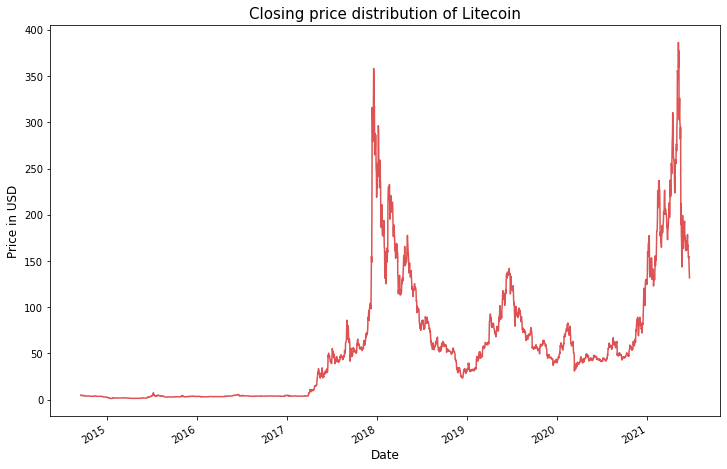

In [4]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(12,8))

sns.lineplot(y = base_df.Close.values, x=base_df.index.values, alpha=0.8, color=color[3])
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y.%m.%d'))
fig.autofmt_xdate()
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price in USD', fontsize=12)
plt.title("Closing price distribution of Litecoin", fontsize=15)
plt.show()

## Candlestick chart

In [5]:
import matplotlib.ticker as mticker
import mplfinance as mpf

#base_df['Date_mpl'] = base_df['Date'].apply(lambda x: mdates.date2num(x))

temp_base_df = base_df.copy(deep=False)
#temp_base_df = temp_base_df.set_index(['Date'])
temp_base_df = temp_base_df.drop(['Spread'], axis=1)
temp_base_df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-09-16,5.170770,4.965950,5.085890,5.058550,3.071840e+06,5.058550
2014-09-17,5.065430,4.579960,5.065430,4.685230,4.569260e+06,4.685230
2014-09-18,4.755820,4.254350,4.687290,4.327770,3.917450e+06,4.327770
2014-09-19,4.616080,4.202190,4.329200,4.286440,5.490660e+06,4.286440
2014-09-20,4.300130,4.154990,4.263070,4.245920,2.931220e+06,4.245920
...,...,...,...,...,...,...
2021-06-16,173.251129,163.589203,166.603317,167.055695,2.010202e+09,167.055695
2021-06-17,167.378906,152.005493,167.234039,156.355637,2.163514e+09,156.355637
2021-06-18,160.827362,152.937836,156.554199,153.295456,1.718600e+09,153.295456


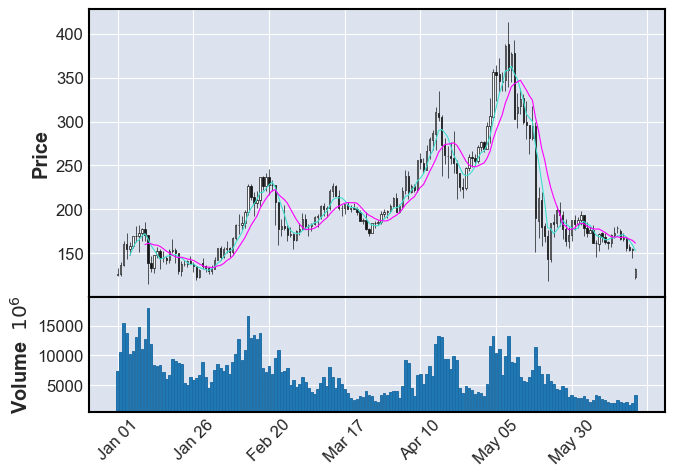

In [6]:
mpf.plot(temp_base_df.loc['2021-1-1':], type='candle', mav=(5,10), volume=True)

## Future Price Prediction

In [7]:
from fbprophet import Prophet

In [8]:
base_df

,High,Low,Open,Close,Volume,Adj Close,Spread
Date,,,,,,,
2014-09-16,5.170770,4.965950,5.085890,5.058550,3.071840e+06,5.058550,0.204820
2014-09-17,5.065430,4.579960,5.065430,4.685230,4.569260e+06,4.685230,0.485470
2014-09-18,4.755820,4.254350,4.687290,4.327770,3.917450e+06,4.327770,0.501470
2014-09-19,4.616080,4.202190,4.329200,4.286440,5.490660e+06,4.286440,0.413890
2014-09-20,4.300130,4.154990,4.263070,4.245920,2.931220e+06,4.245920,0.145140
...,...,...,...,...,...,...,...
2021-06-16,173.251129,163.589203,166.603317,167.055695,2.010202e+09,167.055695,9.661926
2021-06-17,167.378906,152.005493,167.234039,156.355637,2.163514e+09,156.355637,15.373413
2021-06-18,160.827362,152.937836,156.554199,153.295456,1.718600e+09,153.295456,7.889526


In [9]:
price_predict_df = base_df['Close'].copy(deep=False).reset_index()
price_predict_df.columns = ["ds", "y"]
price_predict_df = price_predict_df[price_predict_df['ds']>'2020-6-1']
price_predict_df

,ds,y
2085,2020-06-02,47.172894
2086,2020-06-03,47.637596
2087,2020-06-04,47.053146
2088,2020-06-05,46.731956
2089,2020-06-06,46.668003
...,...,...
2461,2021-06-16,167.055695
2462,2021-06-17,156.355637
2463,2021-06-18,153.295456
2464,2021-06-19,155.092590


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
382,2021-06-25,175.297282,139.838356,208.327636
383,2021-06-26,175.119482,139.731273,209.089279
384,2021-06-27,173.900153,137.606181,209.020977
385,2021-06-28,174.352338,139.529790,209.553044
386,2021-06-29,169.963161,134.890887,205.271833


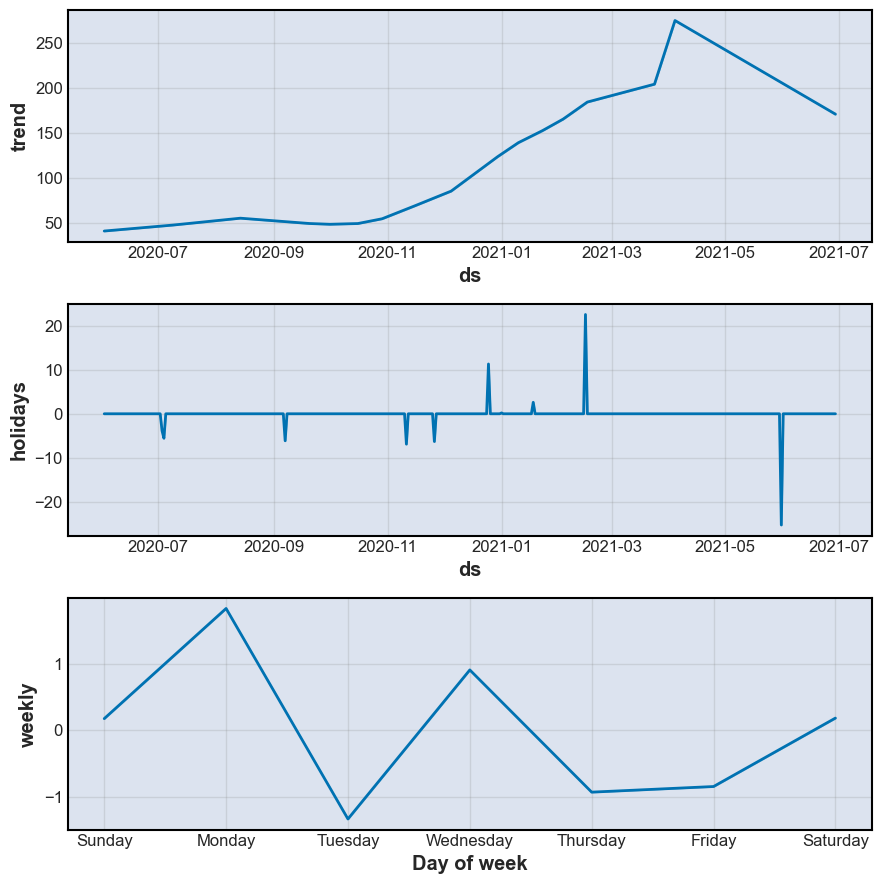

In [13]:
m = Prophet(changepoint_prior_scale=.7)
m.add_country_holidays(country_name='US')
m.fit(price_predict_df);
m.train_holiday_names

future = m.make_future_dataframe(periods=7)

forecast = m.predict(future)
fig = m.plot_components(forecast)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

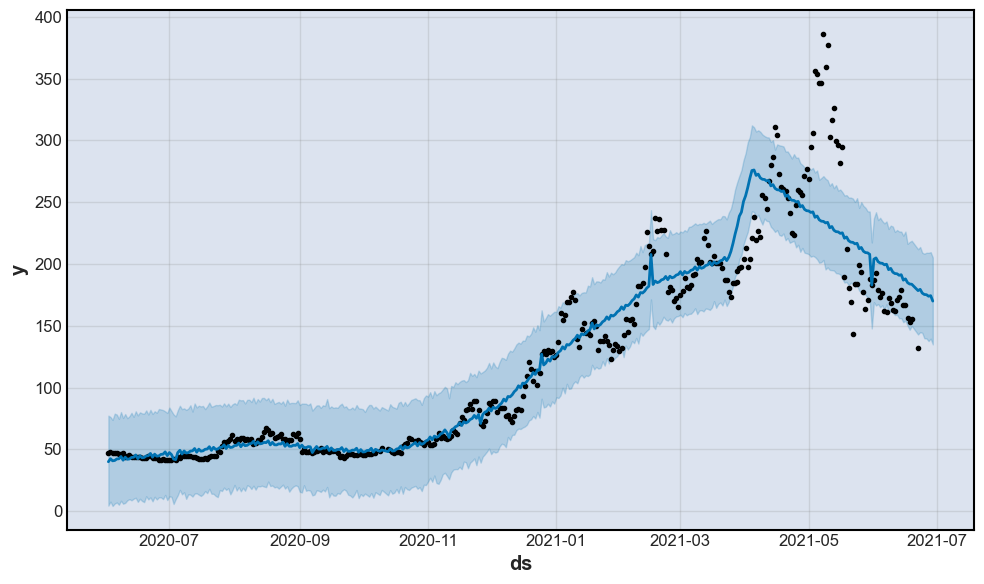

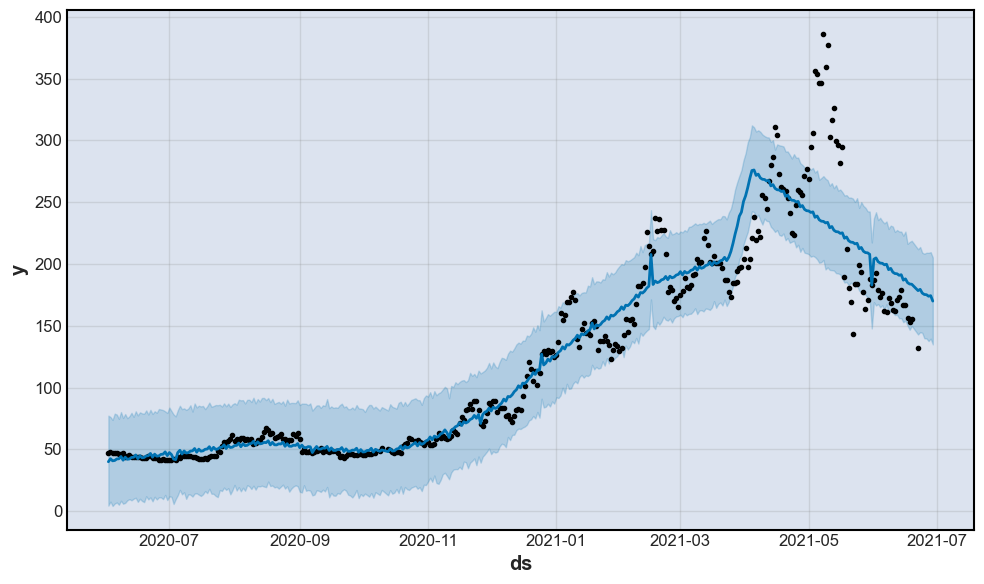

In [14]:
m.plot(forecast)